# Transferring Labels Using UCE

This notebook walks through the example from Figure 4d,4e of transferring labels from mouse kidney norn cells to a human lung disease dataset.

To transfer labels, we use a basic default implementation of sklearn's logistic classifier.

In [1]:
## Imports
import scanpy as sc
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
sc._settings.settings._vector_friendly=True
import matplotlib
import matplotlib.pyplot as plt

## Seed
np.random.seed(0)
random.seed(0)

## Load in anndatas
You can download the anndatas here: https://drive.google.com/drive/folders/1f63fh0ykgEhCrkd_EVvIootBw7LYDVI7

In [2]:
epo_uce = sc.read("mouse_kidney_norn.h5ad")
kam_20_uce = sc.read("human_lung_disease.h5ad")

### Train Classifier on Mouse Kidney Cells

We train a classifier to predict coarsened cell types, from the UCE embeddings

In [3]:
epo_map = {
    "Norn":"Norn",
    "Proximal tubule":"Proximal tubule",
    "Collecting duct principal":"Collecting duct",
    "Distal convoluted tubule":"Distal convoluted tubule",
    "Fibroblasts":"Fibroblast",
    "Endothelial":"Endothelial",
    "Collecting duct transient":"Collecting duct",
    "Other":"misc",
    "Pericyte Ren1+":"Pericyte",
    "Podocytes":"Podocyte",
    "Pericyte3":"Pericyte",
    "Pericyte1":"Pericyte",
    "Pericyte2":"Pericyte",
    "Collecting duct intercalated":"Collecting duct",
    "Loop of henle":"Loop of henle",
    "Proximal tubule2":"Proximal tubule",
    "Macrophages":"Macrophage",
    "Neutrophil":"Granulocyte",
    "T lymphocyte":"T cell",
    "Collecting duct":"Collecting duct",
    "Monocytes":"Monocyte",
    
} # coarse cell type map

In [4]:
epo_uce_no_misc = epo_uce[epo_uce.obs.group != "Other"] # remove misc cells
X = epo_uce_no_misc.obsm["X_uce"] # input is UCE embeddings
y = [epo_map[ct] for ct in epo_uce_no_misc.obs["group"].values] # output is mapped cell types
clf = LogisticRegression(random_state=0).fit(X, y) # fit classifier

### Predict norn-like cells using classifier

In [5]:
kam_20_uce.obs["pred"] = clf.predict(kam_20_uce.obsm["X_uce"]) # predict cell types for lung disease dataset

In [6]:
kam_20_uce.obs["pred"].value_counts()

pred
Proximal tubule    119834
T cell              93556
Granulocyte         52485
Macrophage          11800
Endothelial          7233
Norn                 6005
Podocyte             4270
Pericyte             1316
Fibroblast            623
Monocyte               56
Loop of henle          23
Name: count, dtype: int64

# Check Differential Expression

In [7]:
# Preproccess Count Values
sc.pp.highly_variable_genes(kam_20_uce, n_top_genes=8000, flavor="seurat_v3", subset=True)
sc.pp.normalize_per_cell(kam_20_uce)
sc.pp.log1p(kam_20_uce)

In [8]:
# Subset to predicted Norn-like cells
kam20_norn_ad = kam_20_uce[kam_20_uce.obs.pred == "Norn"].copy()

In [9]:
all_de_dfs = {}
ngenes = 4

In [10]:
sc.tl.rank_genes_groups(kam20_norn_ad, groupby="Disease_Identity", use_raw=False, reference="Control") # DE, diseases vs control

In [11]:
de_df = sc.get.rank_genes_groups_df(kam20_norn_ad, group="COPD") # get COPD vs control results
all_de_dfs["copd_vs_control"] = de_df[~de_df.index.isin(de_df.iloc[10:-10].index)] # top 10 and bottom 10 genes
copd_control_genes = list(de_df.head(ngenes)["names"].values)

In [12]:
de_df = sc.get.rank_genes_groups_df(kam20_norn_ad, group="IPF") # get IPF vs control results
all_de_dfs["ipf_vs_control"] = de_df[~de_df.index.isin(de_df.iloc[10:-10].index)] # top 10 and bottom 10 genes
ipf_control_genes = list(de_df.head(ngenes)["names"].values)

In [13]:
sc.tl.rank_genes_groups(kam20_norn_ad, groupby="Disease_Identity", use_raw=False, reference="IPF") # DE, all vs IPF

In [14]:
de_df = sc.get.rank_genes_groups_df(kam20_norn_ad, group="COPD") # COPD vs IPF
all_de_dfs["copd_vs_ipf"] = de_df[~de_df.index.isin(de_df.iloc[10:-10].index)] # top 10 and bottom 10 genes
copd_ipf_genes = list(de_df.head(ngenes)["names"].values)

In [15]:
sc.tl.rank_genes_groups(kam20_norn_ad, groupby="Disease_Identity", use_raw=False, reference="COPD") # DE, all vs COPD

In [16]:
de_df = sc.get.rank_genes_groups_df(kam20_norn_ad, group="IPF") # IPF vs COPD
all_de_dfs["ipf_vs_copd"] = de_df[~de_df.index.isin(de_df.iloc[10:-10].index)] # top 10 and bottom 10 genes
ipf_copd_genes = list(de_df.head(ngenes)["names"].values)

In [17]:
gene_list = ipf_control_genes + copd_control_genes + copd_ipf_genes + ipf_copd_genes

reduced_gene_list = []
for g in gene_list:
    if g in reduced_gene_list:
        next
    else:
        reduced_gene_list.append(g)
reduced_gene_list

['POSTN',
 'COL1A1',
 'COL3A1',
 'SPARC',
 'LUM',
 'MFAP4',
 'PTGDS',
 'PTPRG',
 'GPX3',
 'NAMPT',
 'RPL41',
 'CRISPLD2',
 'SERPINH1',
 'COL1A2']

## Plot Results

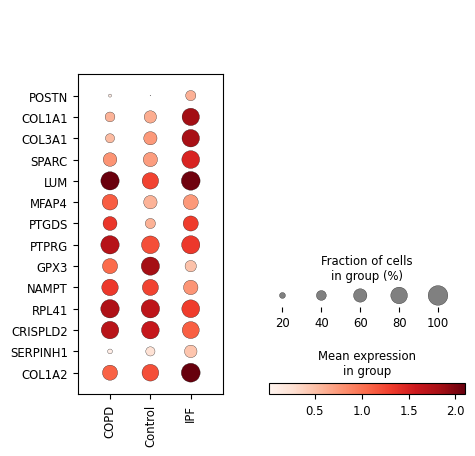

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
sc.pl.dotplot(kam20_norn_ad, groupby="Disease_Identity", var_names=reduced_gene_list, show=True, swap_axes=True, ax=ax)